## Load standard libraries

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [52]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))
y = train.iloc[:, -1]
train = train.iloc[:, 1:-1]
test = test.iloc[:, 1:]
submission = test.iloc[:, 0]

In [91]:
np.shape(train)

(1460, 79)

In [92]:
np.shape(test)

(1459, 79)

In [10]:
for i in train.columns:
    print i,',' ,'{:.1%}'.format(np.mean(train[i].isnull())),'nulls',',',type(train[i][0]), train[i].nunique(), 'unique values'

Id , 0.0% nulls , <type 'numpy.int64'> 1460 unique values
MSSubClass , 0.0% nulls , <type 'numpy.int64'> 15 unique values
MSZoning , 0.0% nulls , <type 'str'> 5 unique values
LotFrontage , 17.7% nulls , <type 'numpy.float64'> 110 unique values
LotArea , 0.0% nulls , <type 'numpy.int64'> 1073 unique values
Street , 0.0% nulls , <type 'str'> 2 unique values
Alley , 93.8% nulls , <type 'float'> 2 unique values
LotShape , 0.0% nulls , <type 'str'> 4 unique values
LandContour , 0.0% nulls , <type 'str'> 4 unique values
Utilities , 0.0% nulls , <type 'str'> 2 unique values
LotConfig , 0.0% nulls , <type 'str'> 5 unique values
LandSlope , 0.0% nulls , <type 'str'> 3 unique values
Neighborhood , 0.0% nulls , <type 'str'> 25 unique values
Condition1 , 0.0% nulls , <type 'str'> 9 unique values
Condition2 , 0.0% nulls , <type 'str'> 8 unique values
BldgType , 0.0% nulls , <type 'str'> 5 unique values
HouseStyle , 0.0% nulls , <type 'str'> 8 unique values
OverallQual , 0.0% nulls , <type 'numpy.in

In [57]:
type(train['BsmtExposure'][0]) == str

True

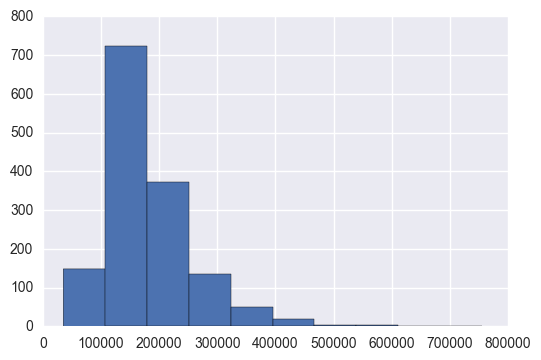

In [11]:
train['SalePrice'].hist()

## Variable exploration

#### MSSubClass

Becuase this is actually a categorical variable, we'll convert it to a string in the feature engineering section.

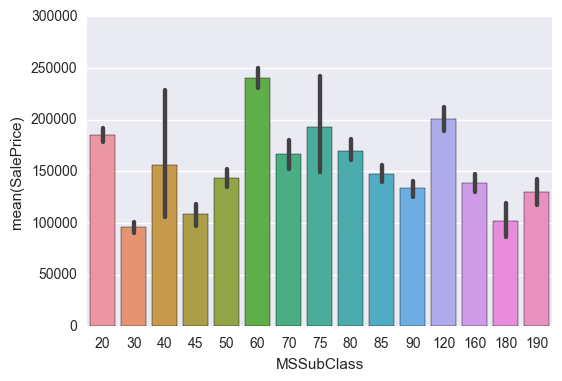

In [12]:
sns.barplot(x=train['MSSubClass'], y=train['SalePrice'])

#### MSZoning

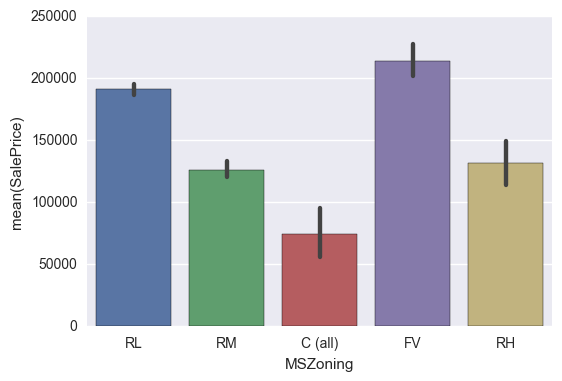

In [15]:
sns.barplot(x=train['MSZoning'], y=train['SalePrice'])

#### LotFrontage

This column has 17.7% nulls, so we will need to impute the nulls using the mean.

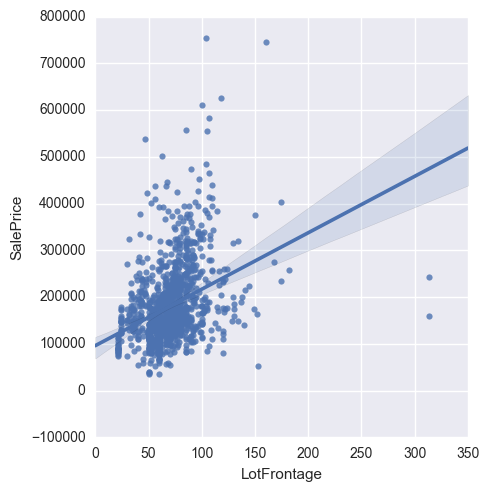

In [16]:
sns.lmplot('LotFrontage', 'SalePrice', train)

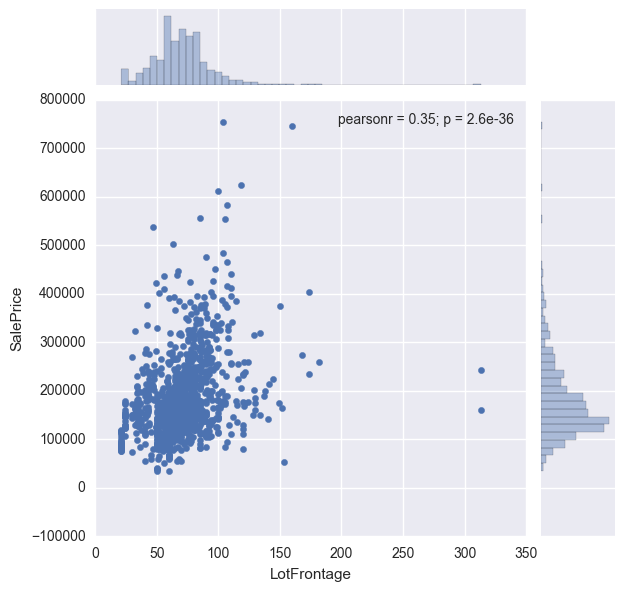

In [21]:
sns.jointplot(x='LotFrontage', y='SalePrice', data=train, kind='scatter')

#### LotArea
This is one clear example where we'll need to scale the values. 

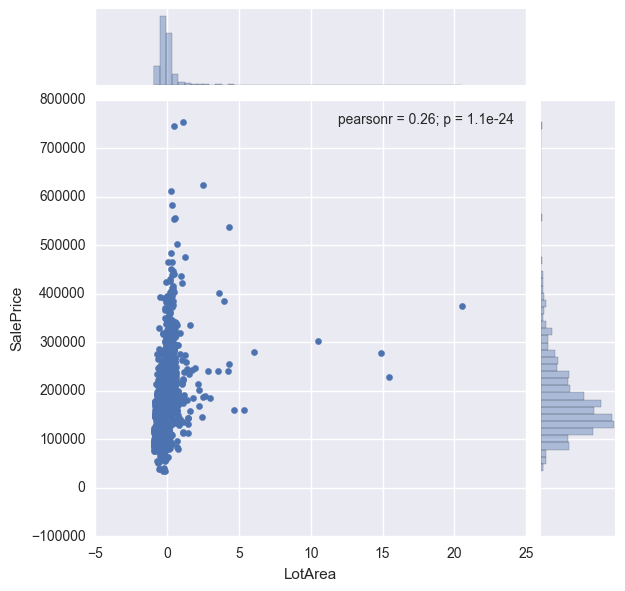

In [40]:
sns.jointplot(x='LotArea', y='SalePrice', data=train, kind='scatter')

#### Street

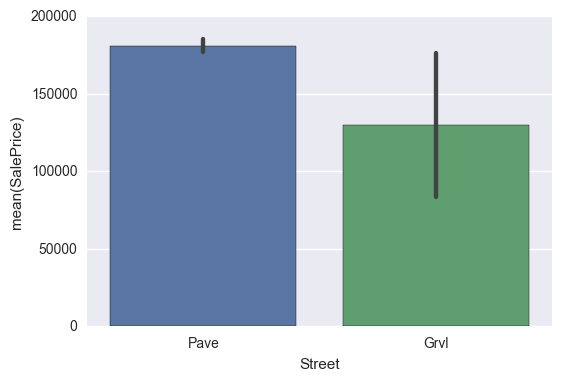

In [43]:
sns.barplot(x='Street', y='SalePrice', data=train)

#### Alley  

93.8% nulls...
We'll leave the nulls as is and one-hot encode.

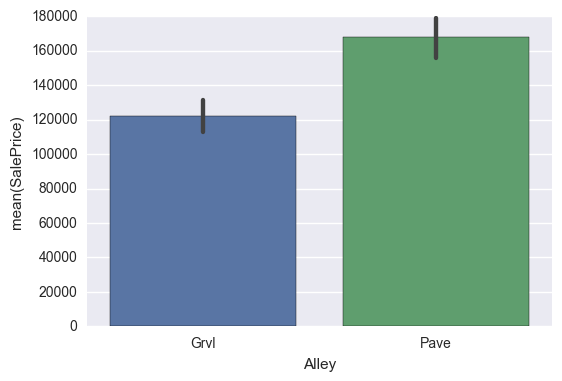

In [45]:
sns.barplot(x='Alley', y='SalePrice', data=train)

#### LotShape

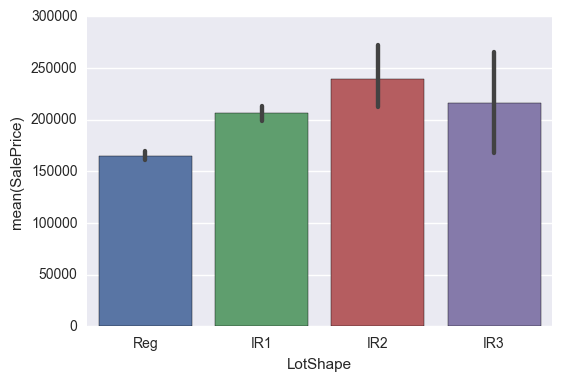

In [46]:
sns.barplot(x='LotShape', y='SalePrice', data=train)

#### LandContour

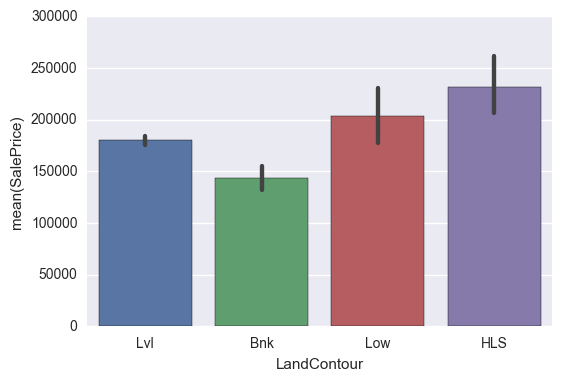

In [47]:
sns.barplot(x='LandContour', y='SalePrice', data=train)

In [50]:
train['LandContour'].value_counts()

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

#### Utilities

This is a useless feature: not enough variability.

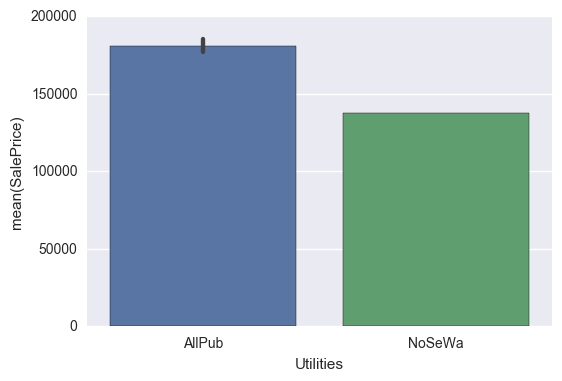

In [48]:
sns.barplot(x='Utilities', y='SalePrice', data=train)

In [49]:
train['Utilities'].value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

#### YearBuilt

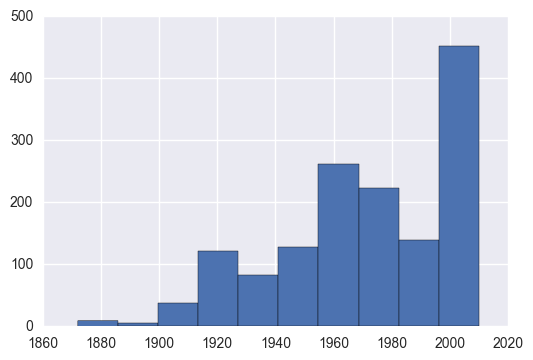

In [58]:
train['YearBuilt'].hist()

#### YearRemodAdd

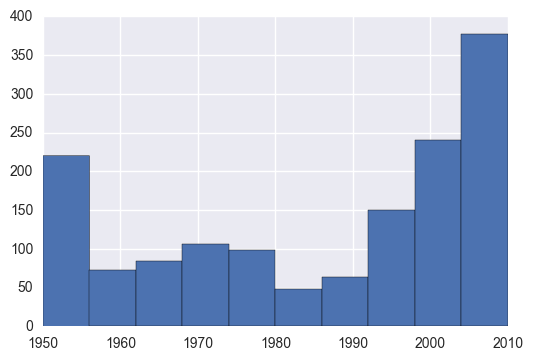

In [62]:
train['YearRemodAdd'].hist()

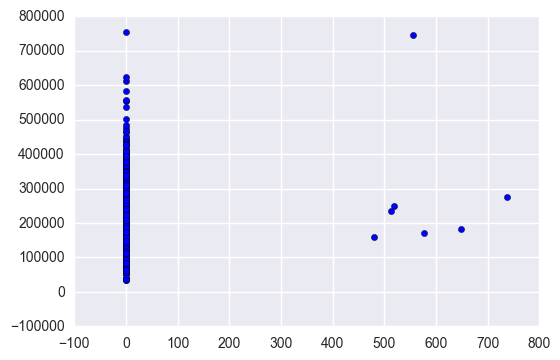

In [74]:
plt.scatter(train['PoolArea'], train['SalePrice'])

#### MasVnrArea

Looks like we have a lot of zeros, and we'll have to impute some of the nulls as well. I choose to replace the nulls with zeros.

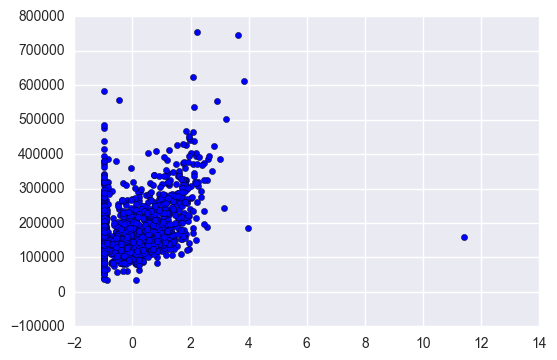

In [79]:
plt.scatter(train['BsmtFinSF1'], train['SalePrice'])

## Fature engineering

In [93]:
def mssubclass(train, test):
    for i in (train, test):
        i['MSSubClass'] = i['MSSubClass'].apply(lambda x: str(x))
    return train, test

In [137]:
train, test = mssubclass(train, test)

In [95]:
def lotfrontage(train, test):
    for i in (train, test):
        i['LotFrontage'] = i['LotFrontage'].fillna(train['LotFrontage'].mean())
    return train, test

In [138]:
train, test = lotfrontage(train, test)

In [97]:
def garageyrblt(train, test):
    for i in (train, test):
        i['GarageYrBlt'] = i['GarageYrBlt'].fillna(train['GarageYrBlt'].mean())
    return train, test

In [139]:
train, test = garageyrblt(train, test)

In [99]:
def impute(train, test):
    for i in (train, test):
        for s in ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 
                              'BsmtFinSF2', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
                              'GrLivArea', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
                              'ScreenPorch', 'PoolArea', 'BsmtUnfSF', 'TotalBsmtSF', 
                              'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']:
            i[s] = i[s].fillna(0)
    return train, test

In [140]:
train, test = impute(train, test)

In [134]:
def log(train, test, y):
    for i in (train, test):
        for z in train.columns[train.dtypes != object]:
            i[z] = np.log(i[z] + 1)
    y = np.log(y)
    return train, test, y

In [135]:
train, test, y = log(train, test, y)

In [84]:
from sklearn.preprocessing import StandardScaler

def scale(train, test, cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 
                              'BsmtFinSF2', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 
                              'GrLivArea', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
                              'ScreenPorch', 'PoolArea']):
    for i in cols:
        sc = StandardScaler()
        train[i] = sc.fit_transform(train[i].reshape(-1,1))
        test[i] = sc.transform(test[i].reshape(-1,1))
    return train, test

In [141]:
train, test = scale(train, test)

In [86]:
import timeit

def dummies(train, test):
    start = timeit.default_timer()
    columns = [i for i in train.columns if type(train[i].iloc[1]) == str or type(train[i].iloc[1]) == float]
    for column in columns:
        train[column].fillna('NULL', inplace = True)
        good_cols = [column+'_'+i for i in train[column].unique()[1:] if i in test[column].unique()]
        train = pd.concat((train, pd.get_dummies(train[column], prefix = column)[good_cols]), axis = 1)
        test = pd.concat((test, pd.get_dummies(test[column], prefix = column)[good_cols]), axis = 1)
        del train[column]
        del test[column]
    print timeit.default_timer() - start, 'seconds'
    return train, test

In [142]:
train, test = dummies(train, test)

0.767923694842 seconds


In [60]:
def ordinal(train, test):
    translation_table = {              'FireplaceQu': {'Ex': 5, 
                                                'Gd': 4, 
                                                'TA': 3, 
                                                'Fa': 2,
                                                'Po': 1,
                                                'NoFireplace': 0 
                                                },
                                 'Fence': {'GdPrv': 2, 
                                           'GdWo': 2, 
                                           'MnPrv': 1, 
                                           'MnWw': 1,
                                           'NoFence': 0},
                                 'ExterQual': {'Ex': 5, 
                                                'Gd': 4, 
                                                'TA': 3, 
                                                'Fa': 2,
                                                'Po': 1
                                                },
                                 'ExterCond': {'Ex': 5, 
                                                'Gd': 4, 
                                                'TA': 3, 
                                                'Fa': 2,
                                                'Po': 1
                                                },
                                 'BsmtQual': {'Ex': 5, 
                                                'Gd': 4, 
                                                'TA': 3, 
                                                'Fa': 2,
                                                'Po': 1,
                                                'NoBsmt': 0},
                                 'BsmtExposure': {'Gd': 3, 
                                                'Av': 2, 
                                                'Mn': 1,
                                                'No': 0,
                                                'NoBsmt': 0},
                                 'BsmtCond': {'Ex': 5, 
                                                'Gd': 4, 
                                                'TA': 3, 
                                                'Fa': 2,
                                                'Po': 1,
                                                'NoBsmt': 0},
                                 'GarageQual': {'Ex': 5, 
                                                'Gd': 4, 
                                                'TA': 3, 
                                                'Fa': 2,
                                                'Po': 1,
                                                'NoGarage': 0},
                                 'GarageCond': {'Ex': 5, 
                                                'Gd': 4, 
                                                'TA': 3, 
                                                'Fa': 2,
                                                'Po': 1,
                                                'NoGarage': 0},
                                 'KitchenQual': {'Ex': 5, 
                                                'Gd': 4, 
                                                'TA': 3, 
                                                'Fa': 2,
                                                'Po': 1},
                                 'HeatingQC': {'Ex': 5, 
                                                'Gd': 4, 
                                                'TA': 3, 
                                                'Fa': 2,
                                                'Po': 1},
                                 'Functional': {'Typ': 0,
                                                'Min1': 1,
                                                'Min2': 1,
                                                'Mod': 2,
                                                'Maj1': 3,
                                                'Maj2': 4,
                                                'Sev': 5,
                                                'Sal': 6}                             
                                }
    train = train.replace(translation_table)
    test = test.replace(translation_table)
    return train, test

In [61]:
train, test = ordinal(train, test)